In [30]:
from pathlib import Path

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

from timeit import default_timer as timer

import itertools

### Chargement des données

In [2]:
df = pd.read_csv(Path("V2_Plant_Seedlings_DataFrame.csv"))
df.head()

,filepath,species,image_name,height,width,R_mean,G_mean,B_mean,luminosity,sharpness_score,image_size,square
0,Input\Maize\196.png,Maize,196.png,1260,1260,96.623133,95.263001,68.305443,86.730526,371.683979,1587600,square
1,Input\Cleavers\33.png,Cleavers,33.png,352,352,80.315397,70.118769,50.518635,66.984267,39.836262,123904,square
2,Input\Charlock\454.png,Charlock,454.png,990,990,80.529463,75.808330,55.868748,70.735514,305.574312,980100,square
3,Input\Small-flowered Cranesbill\5.png,Small-flowered Cranesbill,5.png,162,162,80.199131,71.348765,45.413733,65.653876,9.546821,26244,square
4,Input\Small-flowered Cranesbill\91.png,Small-flowered Cranesbill,91.png,323,323,83.221012,71.454773,45.279941,66.651909,31.808805,104329,square


### Séparation des jeux d'entraînement et de test

In [14]:
# Train/test split: 80% dans le jeu train, 20% dans le jeu test
train_df,test_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=3,
                                    shuffle=True,
                                    stratify=df['species'])


### Pre-processing

In [15]:
# Définition de la fonction de preprocessing avec segmentation par seuillage

def preprocess_segmentation(threshold):
    def _preprocess_segmentation(input_img):
        img_rgb = np.uint8(input_img)
        img_lab = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2LAB)
        img_lab = cv2.resize(img_lab,(224,224))
        # Création du masque par seuillage
        _,mask = cv2.threshold(img_lab[:,:,1],threshold,255,cv2.THRESH_BINARY_INV)
        # Elimination du bruit par ouverture puis fermeture
        kernel = np.ones((2,2))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        # Application du masque à l'image
        masked_img = cv2.bitwise_and(img_rgb,img_rgb,mask=mask)
        masked_img = np.float32(masked_img)
        return masked_img    
    return _preprocess_segmentation
    

In [16]:
# Paramètres de pre-processing

preprocessing_function = preprocess_segmentation(threshold=118)
rescale_factor = 1./255.
color_mode = 'rgb'
target_size = (224,224)
channels = 3
batch_size = 32

In [18]:
# Instanciation du générateur de données

# Générateur des données d'entraînement: avec augmentation "faible" des données
train_data_generator = ImageDataGenerator(preprocessing_function=preprocessing_function,
                                          rescale=rescale_factor,
                                          rotation_range=90,
                                          width_shift_range=0.05, 
                                          height_shift_range=0.05,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          validation_split=0.2)  # 20% du jeu train réservés pour évaluer le modèle au cours de l'entraînement

# Générateur des données de test: sans augmentation de données
test_data_generator = ImageDataGenerator(preprocessing_function=preprocessing_function,
                                         rescale=rescale_factor)


In [19]:
# Instanciation des itérateurs associés aux trois jeux train, validation et test

train_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                          x_col='filepath',
                                                          y_col='species',
                                                          target_size=target_size,
                                                          color_mode=color_mode,
                                                          class_mode='sparse',
                                                          batch_size=batch_size,
                                                          subset="training")
validation_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                               x_col='filepath',
                                                               y_col='species',
                                                               target_size=target_size,
                                                               color_mode=color_mode,
                                                               class_mode='sparse',
                                                               batch_size=batch_size,
                                                               subset="validation")

test_iterator = train_data_generator.flow_from_dataframe(test_df,
                                                         x_col='filepath',
                                                         y_col='species',
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode='sparse',
                                                         batch_size=batch_size,
                                                         shuffle=False)


Found 3545 validated image filenames belonging to 12 classes.
Found 886 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


In [20]:
# Dictionnaire permettant de retrouver les classes à partir des labels
label2class = {x : y for y, x in train_iterator.class_indices.items()}
label2class

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: "Shepherd's Purse",
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

### Construction du modèle

In [21]:
# Implémentation d'une architecture LeNet: construction séquentielle

model = Sequential()
model.add(Conv2D(filters=30,
                 kernel_size=(5,5),
                 activation='relu',
                 padding='valid',
                 input_shape=(target_size[0],target_size[1],channels)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=16,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=12,activation='softmax'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 220, 220, 30)      2280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 30)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 16)      4336      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 46656)            

In [23]:
# Compilation
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

### Définition des callbacks 

In [25]:
checkpoint_filepath = Path('Model_checkpoint','best_weights.ckpt')
csvlogger_filepath = Path('training_history.csv')

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         factor=0.5,
                                         min_delta=0.01,
                                         mode='max',
                                         patience=10,
                                         verbose=1)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       verbose=1)
    
# Callback pour l'enregistrement de l'historique d'entraînement
csv_logger = CSVLogger(csvlogger_filepath,append=True)

# Callback mesurant la durée de l'entraînement 
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, logs={}):
        self.starttime = timer()
    def on_train_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

### Entraînement du modèle

In [22]:
nb_epochs = 100
training_history = model.fit(train_iterator,validation_data=validation_iterator,
                             epochs=nb_epochs,
                             steps_per_epoch=train_iterator.samples//batch_size,
                             validation_steps=validation_iterator.samples//batch_size,
                             callbacks=[time_callback,reduce_learning_rate,model_checkpoint,csv_logger],
                             verbose=True)

Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 1.6066 - accuracy: 0.4418
Epoch 1: val_accuracy improved from -inf to 0.63079, saving model to lenet_lowaugm_segmentation\best_weights.ckpt
110/110 [==============================] - 103s 930ms/step - loss: 1.6066 - accuracy: 0.4418 - val_loss: 1.0670 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 1.0713 - accuracy: 0.6354
Epoch 2: val_accuracy improved from 0.63079 to 0.70486, saving model to lenet_lowaugm_segmentation\best_weights.ckpt
110/110 [==============================] - 104s 946ms/step - loss: 1.0713 - accuracy: 0.6354 - val_loss: 0.8464 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - ETA: 0s - loss: 0.9207 - accuracy: 0.6917
Epoch 3: val_accuracy improved from 0.70486 to 0.71065, saving model to lenet_lowaugm_segmentation\best_weights.ckpt
110/110 [==============================] - 110s 1s/step - loss: 0

Epoch 26/100
110/110 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.8591
Epoch 26: val_accuracy did not improve from 0.87037
110/110 [==============================] - 99s 898ms/step - loss: 0.3877 - accuracy: 0.8591 - val_loss: 0.4221 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 27/100
110/110 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8597
Epoch 27: val_accuracy did not improve from 0.87037
110/110 [==============================] - 100s 907ms/step - loss: 0.3927 - accuracy: 0.8597 - val_loss: 0.3716 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 28/100
110/110 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.8648
Epoch 28: val_accuracy did not improve from 0.87037
110/110 [==============================] - 101s 917ms/step - loss: 0.3706 - accuracy: 0.8648 - val_loss: 0.5427 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 29/100
110/110 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8671
Epoch 29:

Epoch 52/100
110/110 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9206
Epoch 52: val_accuracy did not improve from 0.89352
110/110 [==============================] - 101s 914ms/step - loss: 0.2029 - accuracy: 0.9206 - val_loss: 0.3503 - val_accuracy: 0.8727 - lr: 2.5000e-04
Epoch 53/100
110/110 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9206
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 53: val_accuracy did not improve from 0.89352
110/110 [==============================] - 100s 909ms/step - loss: 0.2017 - accuracy: 0.9206 - val_loss: 0.3500 - val_accuracy: 0.8889 - lr: 2.5000e-04
Epoch 54/100
110/110 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9283
Epoch 54: val_accuracy did not improve from 0.89352
110/110 [==============================] - 100s 908ms/step - loss: 0.1800 - accuracy: 0.9283 - val_loss: 0.3277 - val_accuracy: 0.8854 - lr: 1.2500e-04
Epoch 55/100
110

Epoch 78/100
110/110 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9399
Epoch 78: val_accuracy did not improve from 0.90509
110/110 [==============================] - 101s 914ms/step - loss: 0.1495 - accuracy: 0.9399 - val_loss: 0.3376 - val_accuracy: 0.8854 - lr: 3.1250e-05
Epoch 79/100
110/110 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9379
Epoch 79: val_accuracy did not improve from 0.90509
110/110 [==============================] - 101s 915ms/step - loss: 0.1543 - accuracy: 0.9379 - val_loss: 0.3169 - val_accuracy: 0.9016 - lr: 3.1250e-05
Epoch 80/100
110/110 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9382
Epoch 80: val_accuracy did not improve from 0.90509
110/110 [==============================] - 100s 911ms/step - loss: 0.1550 - accuracy: 0.9382 - val_loss: 0.3281 - val_accuracy: 0.8877 - lr: 3.1250e-05
Epoch 81/100
110/110 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9

In [23]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 171.0 minutes.


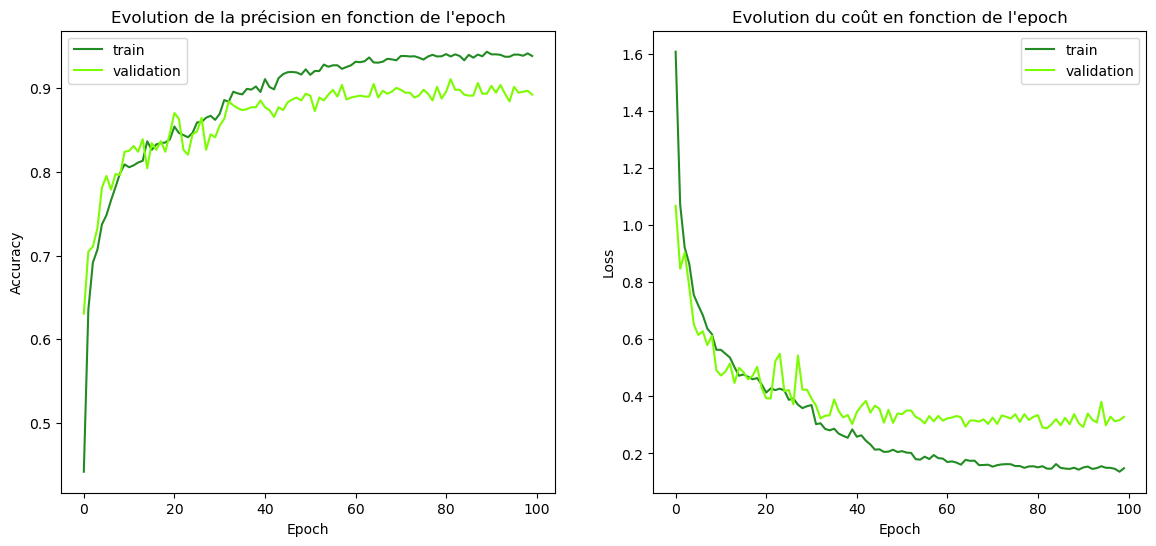

In [26]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement

def plot_history():
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');
    
plot_history()

### Sauvegarde du modèle final avec les meilleurs poids

In [26]:
# Chargement des meilleurs poids
model.load_weights(checkpoint_filepath)

In [28]:
# Sauvegarde au format TensorFlow SavedModel
saving_filepath = Path('Final_model')
model.save(saving_filepath)

INFO:tensorflow:Assets written to: lenet_lowaugm_segmentation\Final_model\assets


INFO:tensorflow:Assets written to: lenet_lowaugm_segmentation\Final_model\assets


### Evaluation du modèle

In [31]:
# Chargement du modèle final
model = load_model(saving_filepath)

In [32]:
# Evaluation sur les jeux train, validation et test
res = pd.DataFrame(index=['train','validation','test'],columns=['loss','accuracy'])
res.iloc[0,:] = model.evaluate(train_iterator)
res.iloc[1,:] = model.evaluate(validation_iterator)
res.iloc[2,:] = model.evaluate(test_iterator)

# Sauvegarde dans un fichier CSV
res.to_csv('lenet_lowaugm_segmentation_results.csv')

35/35 [==============================] - 28s 796ms/step - loss: 0.3102 - accuracy: 0.8971


In [33]:
# Affichage des résultats
res

,loss,accuracy
train,0.146619,0.940762
validation,0.327286,0.892777
test,0.310185,0.897112


35/35 [==============================] - 51s 1s/step
                           precision    recall  f1-score   support

              Black-grass       0.51      0.34      0.41        62
                 Charlock       1.00      0.97      0.98        90
                 Cleavers       0.94      0.94      0.94        67
         Common Chickweed       0.95      0.94      0.94       143
             Common wheat       0.88      0.82      0.85        51
                  Fat Hen       0.92      0.94      0.93       108
         Loose Silky-bent       0.77      0.88      0.82       152
                    Maize       0.91      0.96      0.93        51
        Scentless Mayweed       0.86      0.95      0.91       121
         Shepherd's Purse       0.87      0.82      0.84        55
Small-flowered Cranesbill       0.99      0.94      0.96       115
               Sugar beet       0.93      0.91      0.92        93

                 accuracy                           0.89      1108
       

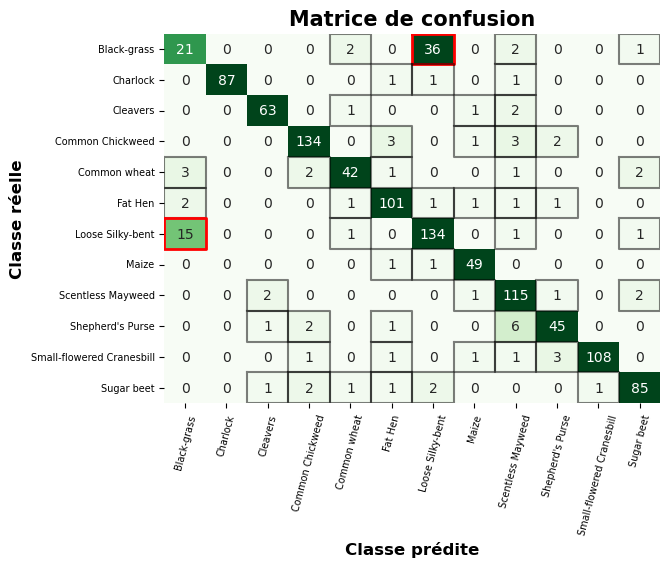

In [12]:
# Rapport de classification & matrice de confusion

def show_metrics():
    y_true = test_iterator.classes
    y_pred = model.predict(test_iterator).argmax(axis=-1)

    print(classification_report(y_true, y_pred, target_names = test_iterator.class_indices.keys()))
    
    matrix = confusion_matrix(y_true, y_pred)
    classes = test_iterator.class_indices.keys()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);

show_metrics()